In [1]:
import pandas as pd
import numpy as np
import spacy
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, classification_report
from sklearn.dummy import DummyClassifier
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer



# colors for the plots
plots_colors = ['#F29F58', '#AB4459', '#441752', '#1B1833']

In [79]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores('block blast overall good difference gameplay ios android user unfair android unlucky start pattern scatter piece board come odd block place spot accord setup give start android high score ios clear board start highscore fix star fix')


{'neg': 0.235, 'neu': 0.65, 'pos': 0.115, 'compound': -0.6908}

In [2]:
df = pd.read_csv("reviews.csv", delimiter=";")
#count different titles
print(f"Your dataset contains : {len(df['title'].unique())} games")
if df.duplicated().sum() == 0:
	print("no duplicates")
else:
	print(f"we deleting {df.duplicated().sum()} duplicates")
	df.drop_duplicates(inplace=True)

print(df.shape)
# print(df[df['score']==2].shape)

Your dataset contains : 374 games
we deleting 1 duplicates
(25174, 7)


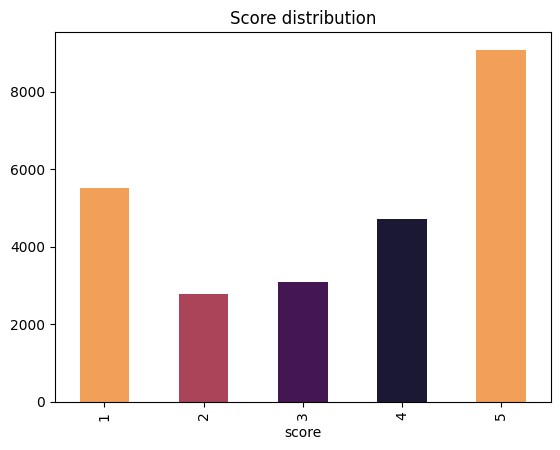

In [3]:
count_class_score = df['score'].value_counts().sort_index()
count_class_score.plot(kind='bar', color=plots_colors)
plt.title('Score distribution')
plt.show()

Here we can see that revieuw with 1 and 5 are the most common and score as 2 3 and 4 is not so common. The issue with this is that score are not balanced. and we cannot 100% say that score 5 has sentiment positive and score 1 has sentiment negative, also its hard to say it for other scores.

In [4]:
analyzer = SentimentIntensityAnalyzer() # VADER sentiment analysis before preprocessing
score_lst_vader_before_preprocessing = []
for i in df.itertuples():
    sentence = analyzer.polarity_scores(i.text)
    score = sentence['compound']
    if score > 0.05:
        sentiment_category = 1
    elif score < -0.05:
        sentiment_category = -1
    else:
        sentiment_category = 0
        
    # combination with stars score
    if sentiment_category == 1 and i.score <= 3:
        sentiment_category-=1  # Downgrade
    elif sentiment_category == -1 and i.score >= 4:
        sentiment_category += 1  # Upgrade
    score_lst_vader_before_preprocessing.append(sentiment_category)

# Preprocessing:
**What can be done to improve the model?**
1. Handling Negations
2. Dealing with Misspellings and Slangs
3. Emoticons and Emojis: Convert them into sentiment indicators.

In [5]:
# Preprocessing : https://medium.com/@maleeshadesilva21/preprocessing-steps-for-natural-language-processing-nlp-a-beginners-guide-d6d9bf7689c9
# 1. lowercasing
# 2. remoce URL if exist
# 3. remoming digits
# 4. removing non-words and non-withespace (e.g emojis,!,?)==> means not Any Alphanumeric character and any white space [^\w\s]
# 5. removing any wors that have less than 3 characters  ===> means boundary of word of any word character that has 1 or 2 characters
# 6. removing stop word and to lemma

common_wods = {"play", 'game', 'time'} # from word cloud where these 3 words are the most common in all 3 sentiments thus not useful
nlp = spacy.load("en_core_web_lg")
def spacy_preprocessor(text):
    doc = nlp(text)
    # Lemmatize, lower text, and remove punctuation and stopwords
    tokens = []
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space and not token.is_digit and token.is_alpha and len(token.text) > 2 and token.text and token.text not in common_wods:
            token = tokens.append(token.lemma_.lower())
    return ' '.join(tokens)
tqdm.pandas(desc="Processing Text")
df['text'] = df['text'].progress_apply(spacy_preprocessor) # +- 4 mins

Processing Text: 100%|██████████| 25174/25174 [04:18<00:00, 97.53it/s] 


In [48]:
new_df = df.assign(vader_score_before_preprocessing=score_lst_vader_before_preprocessing)
df = new_df

In [49]:
score_lst_blob = []
for i in df.itertuples():
    sentence = TextBlob(i.text)
    score = sentence.sentiment.polarity
    if score > 0:
        sentiment_category = 1
    elif score < 0:
        sentiment_category = -1
    else:
        sentiment_category = 0
        
    # combination with stars score
    if sentiment_category == 1 and i.score <= 3:
        sentiment_category-=1  # Downgrade
    elif sentiment_category == -1 and i.score >= 4:
        sentiment_category += 1  # Upgrade
    score_lst_blob.append(sentiment_category)
    

new_df = df.assign(sentiment_blob=score_lst_blob)
df = new_df


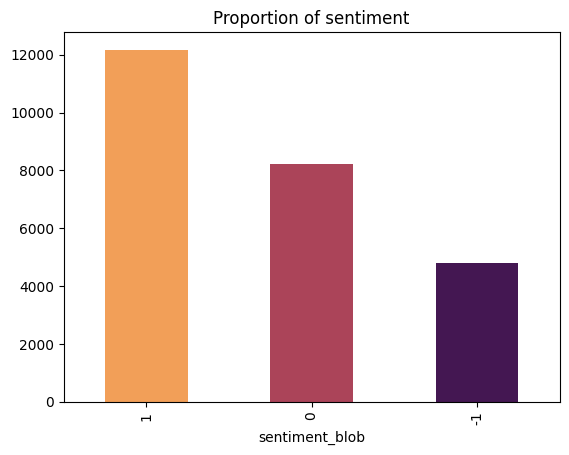

positive sentiment (1): 48.33 %
neutral sentiment (0): 32.64 %
negative sentiment (-1): 19.03 %


In [51]:
count_class = df.value_counts('sentiment_blob')
count_class.plot(kind='bar', color=['#F29F58', '#AB4459', '#441752'])
plt.title('Proportion of sentiment')
plt.show()

print('positive sentiment (1):', round(count_class[1]/df.shape[0]*100,2),"%")
print('neutral sentiment (0):', round(count_class[0]/df.shape[0]*100,2),"%")
print('negative sentiment (-1):', round(count_class[-1]/df.shape[0]*100,2),"%")

In [50]:
analyzer = SentimentIntensityAnalyzer() # VADER sentiment analysis
score_lst_vader = []
for i in df.itertuples():
    sentence = analyzer.polarity_scores(i.text)
    score = sentence['compound']
    if score > 0.05:
        sentiment_category = 1
    elif score < -0.05:
        sentiment_category = -1
    else:
        sentiment_category = 0
        
    # combination with stars score
    if sentiment_category == 1 and i.score <= 3:
        sentiment_category-=1  # Downgrade
    elif sentiment_category == -1 and i.score >= 4:
        sentiment_category += 1  # Upgrade
    score_lst_vader.append(sentiment_category)

new_df = df.assign(sentiment_vader=score_lst_vader)
df = new_df
df.to_csv("reviews_preprocessed.csv", index=False)

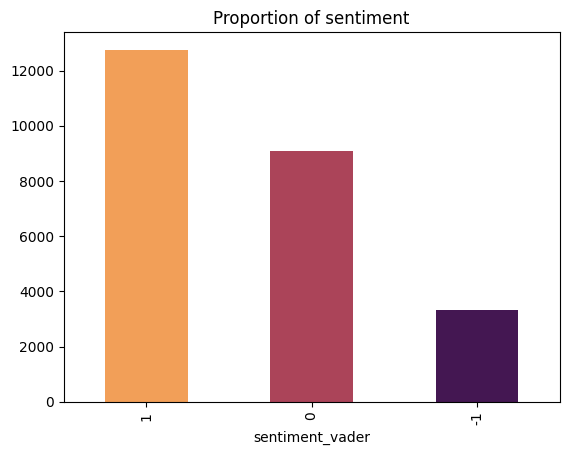

positive sentiment (1): 50.67 %
neutral sentiment (0): 36.08 %
negative sentiment (-1): 13.25 %


In [52]:
count_class = df.value_counts('sentiment_vader')
count_class.plot(kind='bar', color=['#F29F58', '#AB4459', '#441752'])
plt.title('Proportion of sentiment')
plt.show()

print('positive sentiment (1):', round(count_class[1]/df.shape[0]*100,2),"%")
print('neutral sentiment (0):', round(count_class[0]/df.shape[0]*100,2),"%")
print('negative sentiment (-1):', round(count_class[-1]/df.shape[0]*100,2),"%")

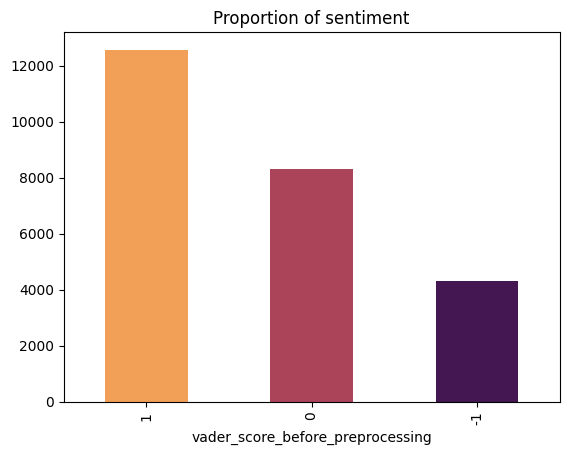

positive sentiment (1): 49.9 %
neutral sentiment (0): 33.03 %
negative sentiment (-1): 17.07 %


In [53]:
count_class = df.value_counts('vader_score_before_preprocessing')
count_class.plot(kind='bar', color=['#F29F58', '#AB4459', '#441752'])
plt.title('Proportion of sentiment')
plt.show()

print('positive sentiment (1):', round(count_class[1]/df.shape[0]*100,2),"%")
print('neutral sentiment (0):', round(count_class[0]/df.shape[0]*100,2),"%")
print('negative sentiment (-1):', round(count_class[-1]/df.shape[0]*100,2),"%")

In [54]:
print("Diff between vader and textblob")
print(df[df['vader_score_before_preprocessing'] != df['sentiment_vader']].shape[0], "out of", df.shape[0])
print("so only", round(df[df['vader_score_before_preprocessing'] != df['sentiment_vader']].shape[0]/df.shape[0]*100,2),"% are different")

Diff between vader and textblob
3124 out of 25174
so only 12.41 % are different


We have unbalanced data meaning, to maybe have better precission, recall, f1 could be good to undersample data or oversample it.

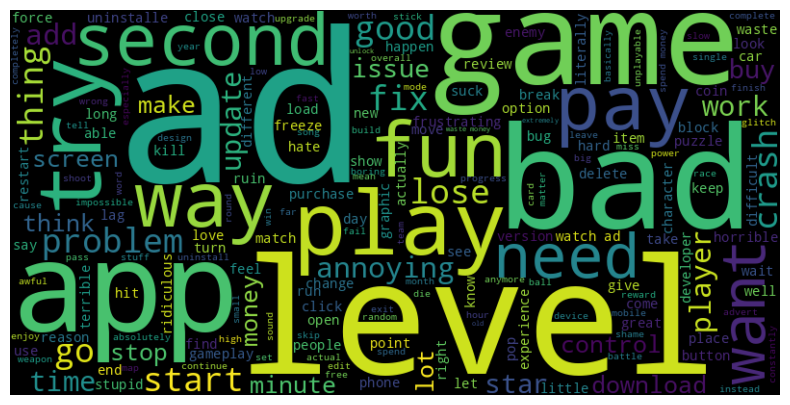

In [64]:
import matplotlib.pyplot as plt
# Most common words in sentiment -1
plt.figure(figsize=(10, 5))
wc = WordCloud(width=800, height=400, max_words=200).generate(' '.join(df[df['sentiment_vader']==-1]['text']))
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')



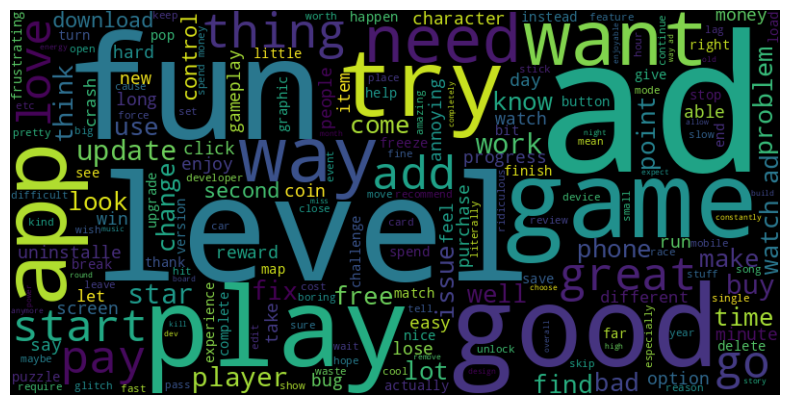

In [65]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Most common words in sentiment neutral
plt.figure(figsize=(10, 5))
wc = WordCloud(width=800, height=400, max_words=200).generate(' '.join(df[df['sentiment_vader']==0]['text']))
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')


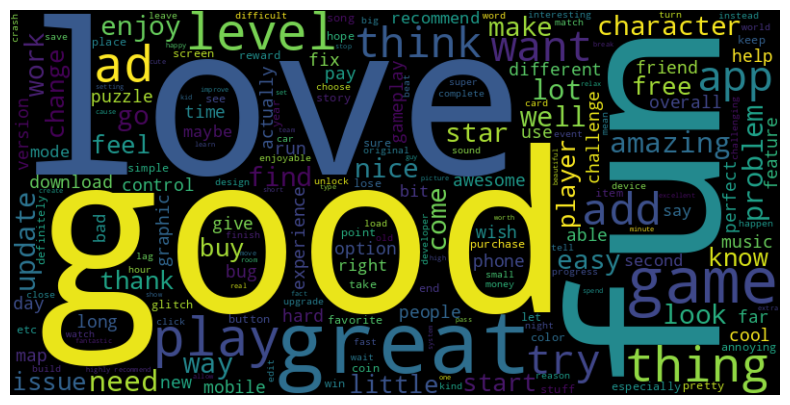

In [66]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Most common words in sentiment -1
plt.figure(figsize=(10, 5))
wc = WordCloud(width=800, height=400, max_words=200).generate(' '.join(df[df['sentiment_vader']==1]['text']))
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')


In [67]:
# X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment_vader'], test_size=0.3, random_state=42)

In [68]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train,y_train)
dummy_clf.predict(X_test)
dummy_clf.score(X_test,y_test)

0.5029789487620813

In [69]:
dummy_clf_2 = DummyClassifier(strategy="stratified")
dummy_clf_2.fit(X_train,y_train)
dummy_clf_2.predict(X_test)
dummy_clf_2.score(X_test,y_test)

0.40394545213822325

In [70]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
# Train the model
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [71]:
y_pred = model.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, y_pred),3))
print(classification_report(y_test, y_pred))

# precision = when model predict class c how often is correct. now when he had to predict 0 = neutral he was correct 26% of the time very poor
# recall = Out of all class c how many did our model predict correctly. recall for class 0 = neutral is 5% very poor

Accuracy: 0.701
              precision    recall  f1-score   support

          -1       0.75      0.21      0.33       986
           0       0.59      0.71      0.64      2768
           1       0.79      0.83      0.81      3799

    accuracy                           0.70      7553
   macro avg       0.71      0.58      0.59      7553
weighted avg       0.71      0.70      0.68      7553



In [72]:
# unbalanced Data => undersampling
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment_blob'], test_size=0.3, random_state=42)

min_class_size = df['sentiment_blob'].value_counts().min()
balanced_training_data = df.groupby('sentiment_blob').apply(lambda x: x.sample(min_class_size)).reset_index(drop=True)

X_train = balanced_training_data['text']
y_train = balanced_training_data['sentiment_blob']

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


/tmp/ipykernel_979349/3129472637.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_training_data = df.groupby('sentiment_blob').apply(lambda x: x.sample(min_class_size)).reset_index(drop=True)


Accuracy: 0.7370581226002912
              precision    recall  f1-score   support

          -1       0.66      0.87      0.75      1462
           0       0.65      0.57      0.61      2457
           1       0.83      0.79      0.81      3634

    accuracy                           0.74      7553
   macro avg       0.72      0.75      0.73      7553
weighted avg       0.74      0.74      0.74      7553

